In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


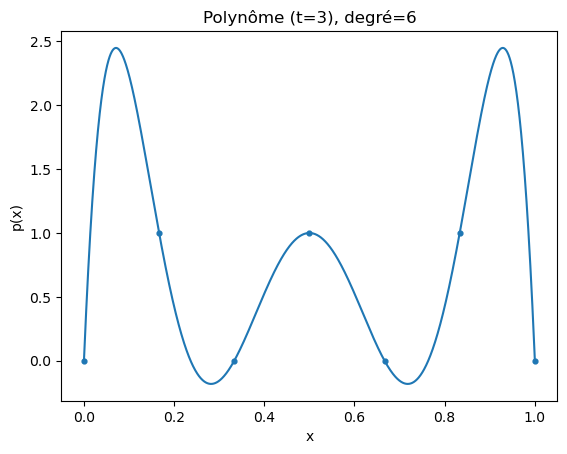

Degree: 6
Min/Max on the grid: -0.18172966580900798 2.4492199174022087


In [4]:
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(0) # for reproductability of our experiences
device = "cpu"

def polyfit_interpolate_triangle(t: int, deg: int = None):
    a = np.linspace(0.0, 1.0, 2*t+1)
    y = np.array([0 if (i%2==0) else 1 for i in range(2*t+1)], dtype=float)  # 0,1,0,1,...
    if deg is None:
        deg = 2*t
    coeffs = np.polyfit(a, y, deg)
    p = np.poly1d(coeffs)
    return p, a, y, deg

t_poly = 3
p, a, y_nodes, deg = polyfit_interpolate_triangle(t_poly)

x = np.linspace(0,1,2000)
y = p(x)

plt.plot(x, y)
plt.scatter(a, y_nodes, s=12)
plt.title(f"Polynôme (t={t_poly}), degré={deg}")
plt.xlabel("x"); plt.ylabel("p(x)")
plt.show()

print("Degree:", deg)
print("Min/Max on the grid:", y.min(), y.max())


In [5]:
def make_dataset(target_fn, n_train=512, noise_std=0.0):
    x = torch.rand(n_train, 1)
    y = target_fn(x)
    if noise_std > 0:
        y = y + noise_std*torch.randn_like(y)
    return x.to(device), y.to(device)

p, _, _, _ = polyfit_interpolate_triangle(t=t_poly)
target_fn = lambda x: torch.tensor(p(x.view(-1).cpu().numpy()), dtype=torch.float32).view(-1,1).to(device)

x_train, y_train = make_dataset(target_fn, n_train=1024, noise_std=0.0)

# test grid dense
x_test = torch.linspace(0,1,4096).view(-1,1).to(device)
y_test = target_fn(x_test).detach()


In [6]:
class DeepNetwork(nn.Module):
    def __init__(self, width: int, depth: int):
        super().__init__()
        layers = [nn.Linear(1, width), nn.ReLU()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.ReLU()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [7]:
@torch.no_grad()
def rmse(model, x, y):
    pred = model(x)
    return torch.sqrt(torch.mean((pred - y)**2)).item()

@torch.no_grad()
def crossing_number(model, x_grid, threshold=0.5):
    y = model(x_grid).view(-1)
    s = torch.sign(y - threshold)
    s_np = s.cpu().numpy()
    for i in range(1, len(s_np)):
        if s_np[i] == 0:
            s_np[i] = s_np[i-1]
    changes = np.sum(s_np[1:] * s_np[:-1] < 0)
    return int(changes)


RMSE test: 0.4580058157444
Cr (tau=0.5): 2


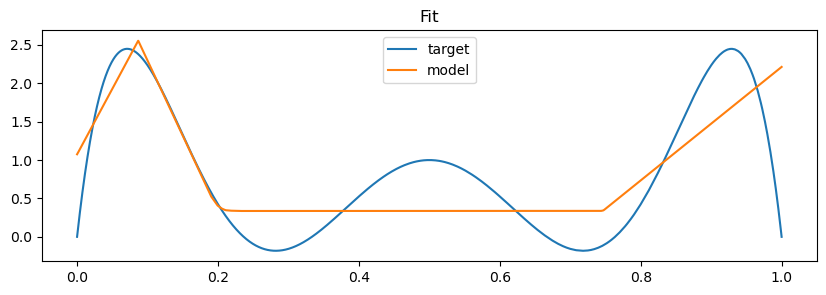

In [8]:
def train_model(width, depth, iters=5000, lr=1e-3, weight_decay=0.0, seed=0):
    set_seed(seed)
    model = DeepNetwork(width=width, depth=depth).to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    for _ in range(iters):
        opt.zero_grad()
        pred = model(x_train)
        loss = loss_fn(pred, y_train)
        loss.backward()
        opt.step()

    return model

m = train_model(width=10, depth=3, iters=3000, seed=0)
print("RMSE test:", rmse(m, x_test, y_test))
print("Cr (tau=0.5):", crossing_number(m, x_test, threshold=0.5))

plt.figure(figsize=(10,3))
with torch.no_grad():
    plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), label="target")
    plt.plot(x_test.cpu().numpy(), m(x_test).cpu().numpy(), label="model")
plt.legend(); plt.title("Fit"); plt.show()


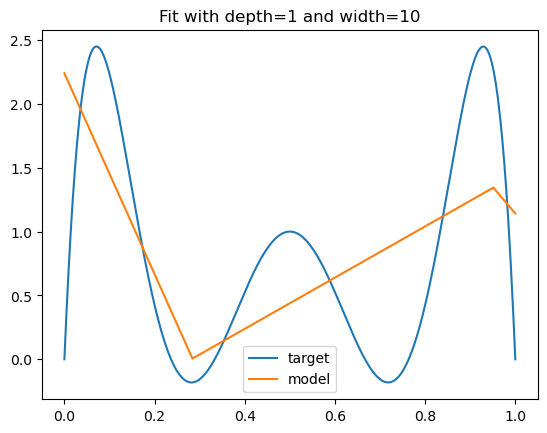

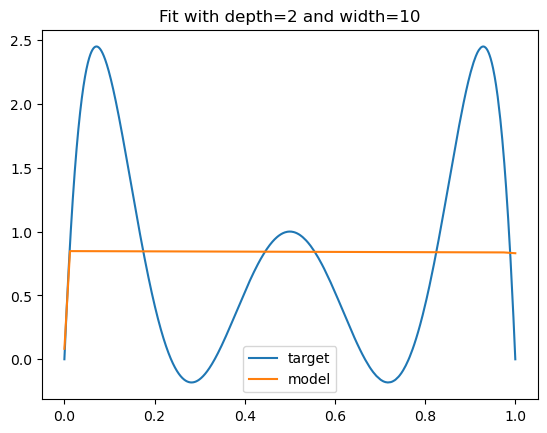

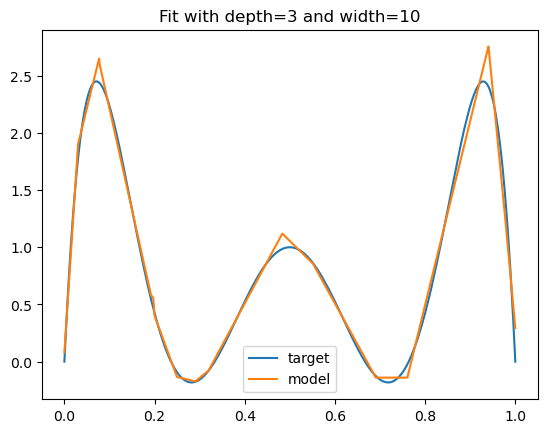

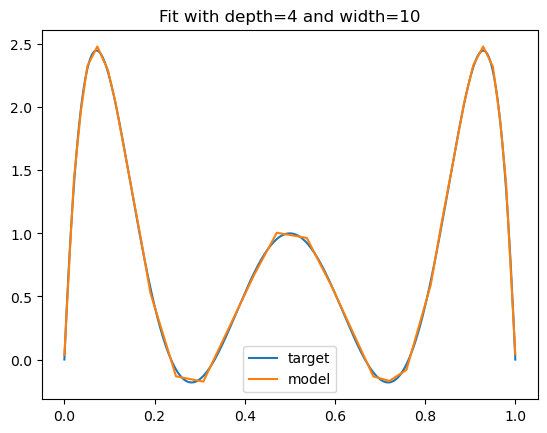

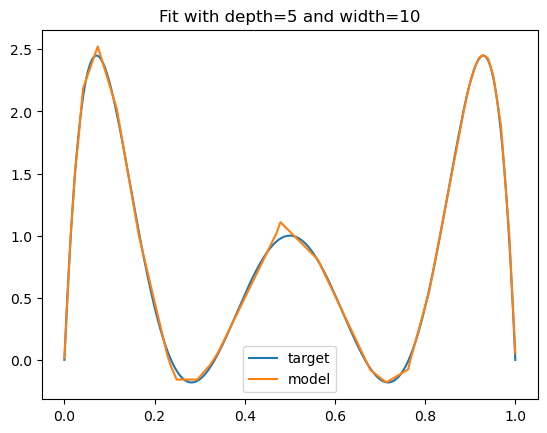

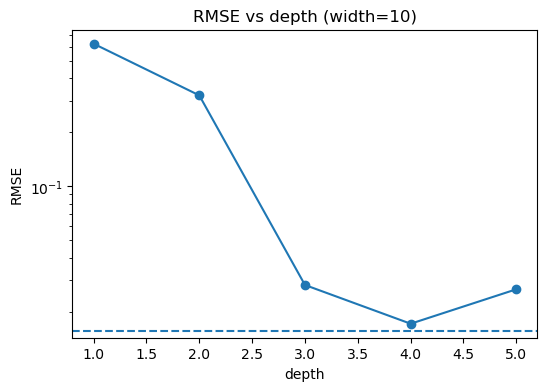

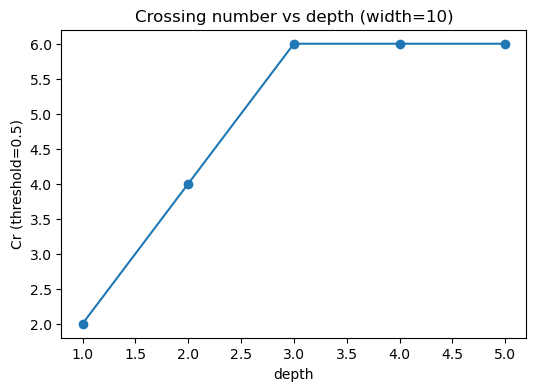

Min depth achieving RMSE < 1/64: None


In [9]:
def sweep_depth(width_fixed, depths, seeds=(0,1,2), iters=5000):
    rows = []
    for d in depths:
        best = None
        best_model = None
        iters = iters + 2000 # we realized a deeper network needs more training to have the same convergence so we add a number of iterations
        for s in seeds:
            model = train_model(width=width_fixed, depth=d, iters=iters, seed=s)
            val = rmse(model, x_test, y_test)
            if (best is None) or (val < best):
                best, best_model = val, model
        cr = crossing_number(best_model, x_test, threshold=0.5)
        rows.append((d, best, cr))
        with torch.no_grad():
            plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), label="target")
            plt.plot(x_test.cpu().numpy(), model(x_test).cpu().numpy(), label="model")
        plt.legend() 
        plt.title(f"Fit with depth={d} and width={width_fixed}")
        plt.show()

    return rows

width_fixed = 10
depths = list(range(1, 6))
rows = sweep_depth(width_fixed, depths, iters=3000)

ds = [r[0] for r in rows]
rmses = [r[1] for r in rows]
crs = [r[2] for r in rows]

plt.figure(figsize=(6,4))
plt.plot(ds, rmses, marker="o")
plt.yscale("log")
plt.axhline(1/64, linestyle="--")
plt.title(f"RMSE vs depth (width={width_fixed})")
plt.xlabel("depth"); plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ds, crs, marker="o")
plt.title(f"Crossing number vs depth (width={width_fixed})")
plt.xlabel("depth"); plt.ylabel("Cr (threshold=0.5)")
plt.show()

# RMSE < 1/64
thr = 1/64
ok = [d for d, e, _ in rows if e < thr]
print("Min depth achieving RMSE < 1/64:", min(ok) if ok else None)



In [ ]:
def sweep_width(widths, depth_fixed, seeds=(0,1,2), iters=5000):
    rows = []
    for width in widths:
        best = None
        best_model = None
        iters += 1000
        for s in seeds:
            model = train_model(width=width, depth=depth_fixed, iters=iters, seed=s)
            val = rmse(model, x_test, y_test)
            if (best is None) or (val < best):
                best, best_model = val, model
        cr = crossing_number(best_model, x_test, threshold=0.5)
        rows.append((width, best, cr))
        with torch.no_grad():
            plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), label="target")
            plt.plot(x_test.cpu().numpy(), model(x_test).cpu().numpy(), label="model")
        plt.legend() 
        plt.title(f"Fit with depth={depth_fixed} and width={width}")
        plt.show()
    return rows

widths = [2, 4, 8, 16, 32, 64]
depth = 3
rows = sweep_width(widths, depth, iters=2000)

ds = [r[0] for r in rows]
rmses = [r[1] for r in rows]
crs = [r[2] for r in rows]

plt.figure(figsize=(6,4))
plt.plot(ds, rmses, marker="o")
plt.yscale("log")
plt.axhline(1/64, linestyle="--")
plt.title(f"RMSE vs width (depth={depth})")
plt.xlabel("depth"); plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ds, crs, marker="o")
plt.title(f"Crossing number vs width (depth={depth})")
plt.xlabel("depth"); plt.ylabel("Cr (threshold=0.5)")
plt.show()

# RMSE < 1/64
thr = 1/64
ok = [d for d, e, _ in rows if e < thr]
print("Min depth achieving RMSE < 1/64:", min(ok) if ok else None)

In [10]:
import os

results_dir = "Results"
os.makedirs(results_dir, exist_ok=True)

In [ ]:
thr = 1/32

@torch.no_grad()
def mae(model, x, y):
    return torch.mean(torch.abs(model(x) - y)).item()

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def best_over_seeds(width, depth, seeds=(0,1,2), iters=5000):
    best_val = None
    best_model = None
    for s in seeds:
        model = train_model(width=width, depth=depth, iters=iters, seed=s)
        val = mae(model, x_test, y_test)
        if (best_val is None) or (val < best_val):
            best_val, best_model = val, model
    return best_val, best_model

def find_width_opt(depth, widths, thr, seeds=(0,1,2), iters=5000, verbose=False):
    hist = []
    for w in widths:
        val, model = best_over_seeds(w, depth, seeds=seeds, iters=iters)
        hist.append((w, val))
        if verbose:
            print(f"[depth={depth}] width={w:>4} -> MAE={val:.6f}")
        if val < thr:
            return w, val, model, hist
    return None, None, None, hist

depth_grid = list(range(2, 6))
width_grid = [2,4,8,16,32,64,128, 256]

results = []
histories = {}
iters = 2000

for d in depth_grid:
    iters+=600
    w_opt, val_opt, best_model, hist = find_width_opt(
        depth=d, widths=width_grid, thr=thr, seeds=(0,1,2), iters=iters, verbose=True
    )
    histories[d] = hist

    if w_opt is None:
        print(f"depth={d}: no width in the grid defined goes under thr={thr}")
        continue

    params = count_params(best_model)
    total_hidden_neurons = d * w_opt 
    avg_neurons_per_layer = w_opt

    results.append((d, w_opt, val_opt, params, total_hidden_neurons, avg_neurons_per_layer))

print("\n Results (depth, width_opt, MAE, #params, total nodes, nodes average over number of layers)")
for r in results:
    print(r)

# MAE vs width (by depth) 
plt.figure(figsize=(7,4))
for d in depths:
    ws = [a for a,_ in histories[d]]
    maes_ = [b for _,b in histories[d]]
    plt.plot(ws, maes_, marker="o", label=f"depth={d}")
plt.axhline(thr, linestyle="--", label=f"thr={thr}")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("width")
plt.ylabel("MAE (test)")
plt.title("MAE vs width (par depth)")
plt.legend()
fig_file = os.path.join(results_dir, "MAE_vs_width_per_depth.png")
plt.savefig(fig_file, dpi=300)
plt.show()

# comparaison on optima
if len(results) > 0:
    ks = [r[0] for r in results]
    widths_opt = [r[1] for r in results]
    params_opt = [r[3] for r in results]
    neurons_opt = [r[4] for r in results]

    plt.figure(figsize=(7,4))
    plt.plot(ks, widths_opt, marker="o")
    plt.xlabel("depth k")
    plt.ylabel("optimal width")
    plt.title("optimal width vs depth (MAE < thr)")
    fig_file = os.path.join(results_dir, "Optimal_width_vs_depth.png")
    plt.savefig(fig_file, dpi=300)
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ks, neurons_opt, marker="o")
    plt.xlabel("depth k")
    plt.ylabel("Total of nodes (k*width_opt)")
    plt.title("Total of nodes required to goes under the threshold vs depth (optima)")
    fig_file = os.path.join(results_dir, "Nodes_required_to_cross_thre.png")
    plt.savefig(fig_file, dpi=300)
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ks, params_opt, marker="o")
    plt.xlabel("depth k")
    plt.ylabel("# parameters")
    plt.title("# parameters of the network vs depth (sur optima)")
    fig_file = os.path.join(results_dir, "Params_shallow_vs_depth.png")
    plt.savefig(fig_file, dpi=300)
    plt.show()

    best_neurons = min(results, key=lambda r: r[4])
    best_params = min(results, key=lambda r: r[3])
    print("\Best (total nodes min):", best_neurons)
    print("Best (#params min):", best_params)
